In [1]:
!git clone https://github.com/deepanshudashora/custom_models.git

Cloning into 'custom_models'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 7), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (25/25), 7.87 KiB | 1.31 MiB/s, done.


In [2]:
!pip3 install torch_lr_finder
!pip3 install torchinfo

In [1]:
# Initialized Logger
import torch
import torch.optim as optim
from torchvision import datasets
import albumentations as A
from torchinfo import summary
from albumentations.pytorch import ToTensorV2
#from src.model import Net
from custom_models.utils import get_device, \
                  fit_model, plot_accuracy_report, \
                  show_random_results, plot_misclassified, \
                  calculate_accuracy_per_class
from custom_models.dataset import dataset_stats,\
                        visualize_images,\
                        visualize_augmentated_images,\
                        Cifar10SearchDataset
from custom_models.custom_resnet import CustomResnet

CODE BLOCK: 2

In [2]:
# CUDA?
device = get_device()
print("Available Device :: ", device)

INFO:custom_models.utils:device: cuda


Available Device ::  cuda


CODE BLOCK: 3

In [3]:
sample = datasets.CIFAR10('./data',train=True,download=True)
sample_data = sample.data

mean,std,var = dataset_stats(sample_data)
print(f"SHAPE of Images {sample_data.shape}")
print(f"MEAN of dataset {mean}")
print(f"STD of dataset {std}")
print(f"VAR of dataset {var}")

Files already downloaded and verified
SHAPE of Images (50000, 32, 32, 3)
MEAN of dataset [0.49139968 0.48215841 0.44653091]
STD of dataset [0.24703223 0.24348513 0.26158784]
VAR of dataset [15.56135559 15.11767693 17.44919073]


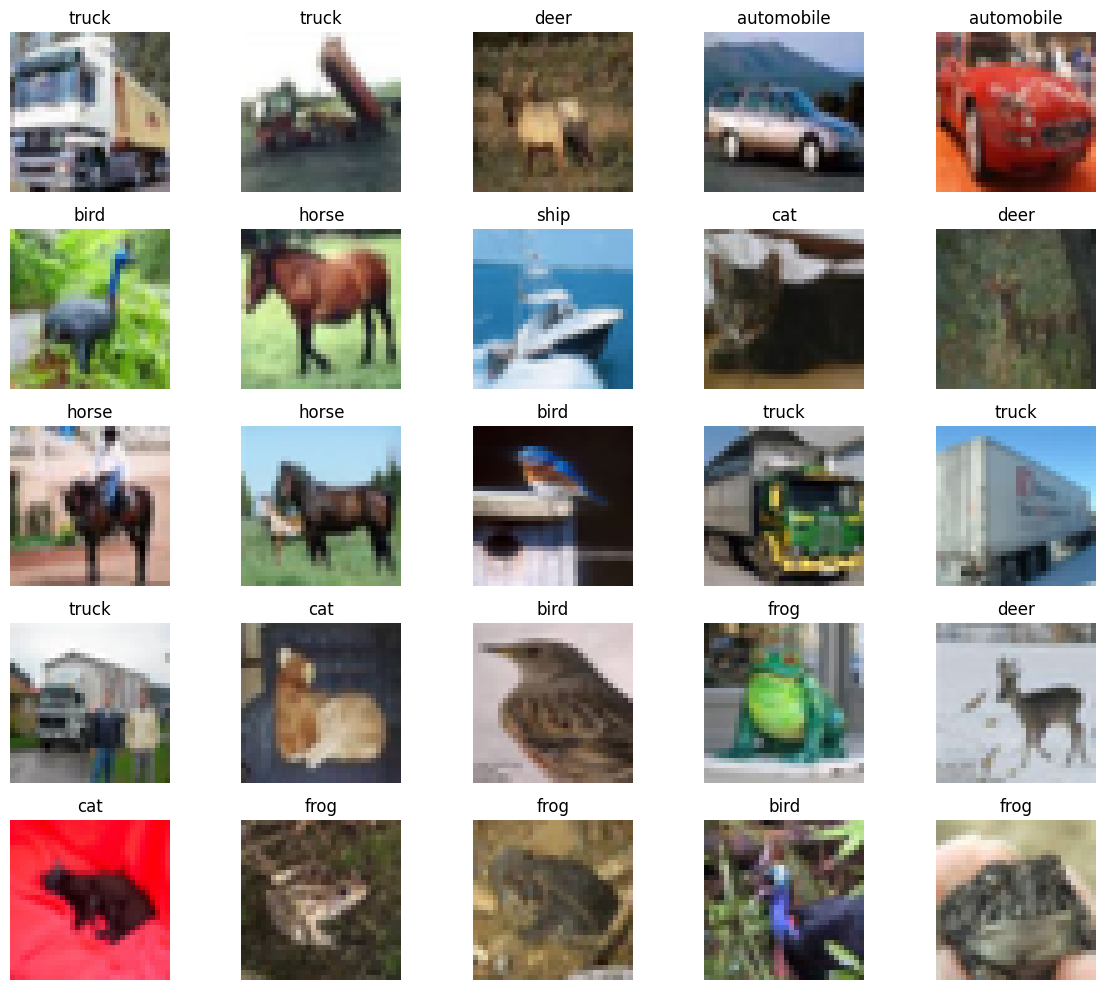

In [4]:
visualize_images(sample,(5,5))

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:133: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)


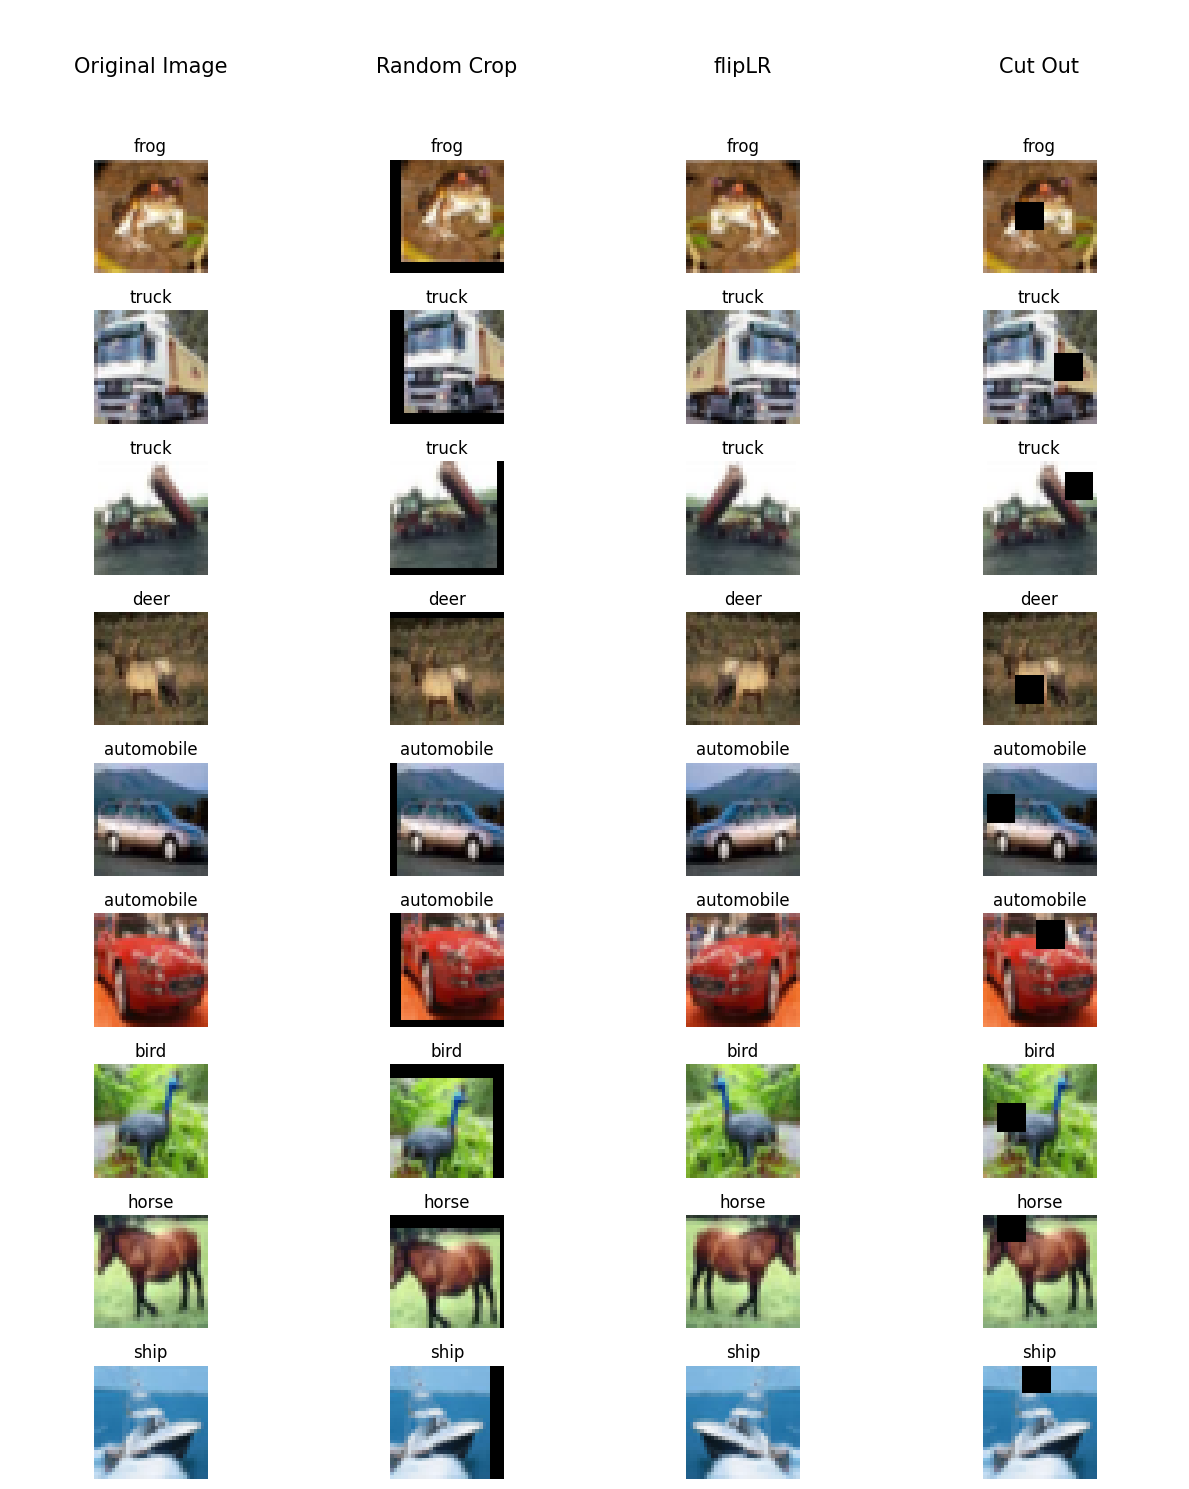

In [5]:
aug_details = {
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'flipLR':A.IAAFliplr (always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                               min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      }

visualize_augmentated_images(sample,aug_details)

In [6]:
train_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
      A.IAAFliplr(always_apply=True),
      A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                            min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      ToTensorV2(),
    ]
)

train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [7]:
model = CustomResnet().to(device)
summary(model, input_size=(512,3, 32, 32),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
CustomResnet                             [512, 10]                 --
├─Sequential: 1-1                        [512, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         1,728
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─ReLU: 2-3                         [512, 64, 32, 32]         --
├─Sequential: 1-2                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [512, 128, 32, 32]        73,728
│    └─MaxPool2d: 2-5                    [512, 128, 16, 16]        --
│    └─BatchNorm2d: 2-6                  [512, 128, 16, 16]        256
│    └─ReLU: 2-7                         [512, 128, 16, 16]        --
├─Sequential: 1-3                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [512, 128, 16, 16]        147,456
│    └─BatchNorm2d: 2-9                  [512, 128, 16, 16]        256


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.63E-02


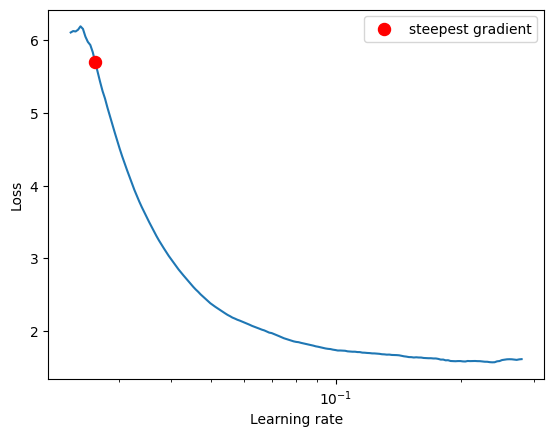

In [8]:
# LR calculation
from torch_lr_finder import LRFinder

model = CustomResnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.3, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [9]:
training_parameters = {"learning_rate":0.02,
                       "max_lr":2.63E-02,
                       "max_at":5/24,
                       "num_epochs":24,
                       "weight_decay":1e-4
                       }
train_losses, test_losses, train_acc, test_acc = fit_model(model,training_parameters,train_loader,test_loader,device)

Epoch 1


Train: Loss=0.9896 Batch_id=97 Accuracy=49.67: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]


Test set: Average loss: 0.0352, Accuracy: 5749/10000 (57.49%)

Epoch 2


Train: Loss=0.9031 Batch_id=97 Accuracy=66.41: 100%|██████████| 98/98 [00:55<00:00,  1.78it/s]


Test set: Average loss: 0.0415, Accuracy: 6078/10000 (60.78%)

Epoch 3


Train: Loss=0.7600 Batch_id=97 Accuracy=72.93: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test set: Average loss: 0.0458, Accuracy: 5723/10000 (57.23%)

Epoch 4


Train: Loss=0.8125 Batch_id=97 Accuracy=75.07: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test set: Average loss: 0.0213, Accuracy: 7388/10000 (73.88%)

Epoch 5


Train: Loss=0.6078 Batch_id=97 Accuracy=77.45: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]


Test set: Average loss: 0.0311, Accuracy: 6495/10000 (64.95%)

Epoch 6


Train: Loss=0.5942 Batch_id=97 Accuracy=79.25: 100%|██████████| 98/98 [00:55<00:00,  1.78it/s]


Test set: Average loss: 0.0149, Accuracy: 7908/10000 (79.08%)

Epoch 7


Train: Loss=0.5721 Batch_id=97 Accuracy=80.88: 100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.0221, Accuracy: 7258/10000 (72.58%)

Epoch 8


Train: Loss=0.4701 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]


Test set: Average loss: 0.0166, Accuracy: 7841/10000 (78.41%)

Epoch 9


Train: Loss=0.5391 Batch_id=97 Accuracy=82.47: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test set: Average loss: 0.0197, Accuracy: 7777/10000 (77.77%)

Epoch 10


Train: Loss=0.4813 Batch_id=97 Accuracy=83.10: 100%|██████████| 98/98 [00:55<00:00,  1.78it/s]


Test set: Average loss: 0.0246, Accuracy: 7658/10000 (76.58%)

Epoch 11


Train: Loss=0.5999 Batch_id=97 Accuracy=83.68: 100%|██████████| 98/98 [00:56<00:00,  1.74it/s]


Test set: Average loss: 0.0148, Accuracy: 8134/10000 (81.34%)

Epoch 12


Train: Loss=0.5599 Batch_id=97 Accuracy=84.15: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]


Test set: Average loss: 0.0149, Accuracy: 7990/10000 (79.90%)

Epoch 13


Train: Loss=0.4244 Batch_id=97 Accuracy=84.81: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]


Test set: Average loss: 0.0194, Accuracy: 7959/10000 (79.59%)

Epoch 14


Train: Loss=0.3439 Batch_id=97 Accuracy=85.41: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]


Test set: Average loss: 0.0162, Accuracy: 8267/10000 (82.67%)

Epoch 15


Train: Loss=0.4656 Batch_id=97 Accuracy=86.24: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]


Test set: Average loss: 0.0133, Accuracy: 8387/10000 (83.87%)

Epoch 16


Train: Loss=0.3544 Batch_id=97 Accuracy=87.00: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test set: Average loss: 0.0123, Accuracy: 8455/10000 (84.55%)

Epoch 17


Train: Loss=0.3888 Batch_id=97 Accuracy=87.08: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]


Test set: Average loss: 0.0129, Accuracy: 8554/10000 (85.54%)

Epoch 18


Train: Loss=0.3228 Batch_id=97 Accuracy=88.53: 100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.0120, Accuracy: 8337/10000 (83.37%)

Epoch 19


Train: Loss=0.2991 Batch_id=97 Accuracy=89.22: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test set: Average loss: 0.0100, Accuracy: 8641/10000 (86.41%)

Epoch 20


Train: Loss=0.3196 Batch_id=97 Accuracy=90.36: 100%|██████████| 98/98 [00:57<00:00,  1.72it/s]


Test set: Average loss: 0.0117, Accuracy: 8698/10000 (86.98%)

Epoch 21


Train: Loss=0.2377 Batch_id=97 Accuracy=92.21: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test set: Average loss: 0.0087, Accuracy: 8891/10000 (88.91%)

Epoch 22


Train: Loss=0.1796 Batch_id=97 Accuracy=93.77: 100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.0073, Accuracy: 8935/10000 (89.35%)

Epoch 23


Train: Loss=0.1149 Batch_id=97 Accuracy=95.62: 100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.0078, Accuracy: 9084/10000 (90.84%)

Epoch 24


Train: Loss=0.1057 Batch_id=97 Accuracy=96.95: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]


Test set: Average loss: 0.0071, Accuracy: 9132/10000 (91.32%)



In [10]:
test_loss_cpu = []
for i in test_losses:
  test_loss_cpu.append(i.cpu().numpy())

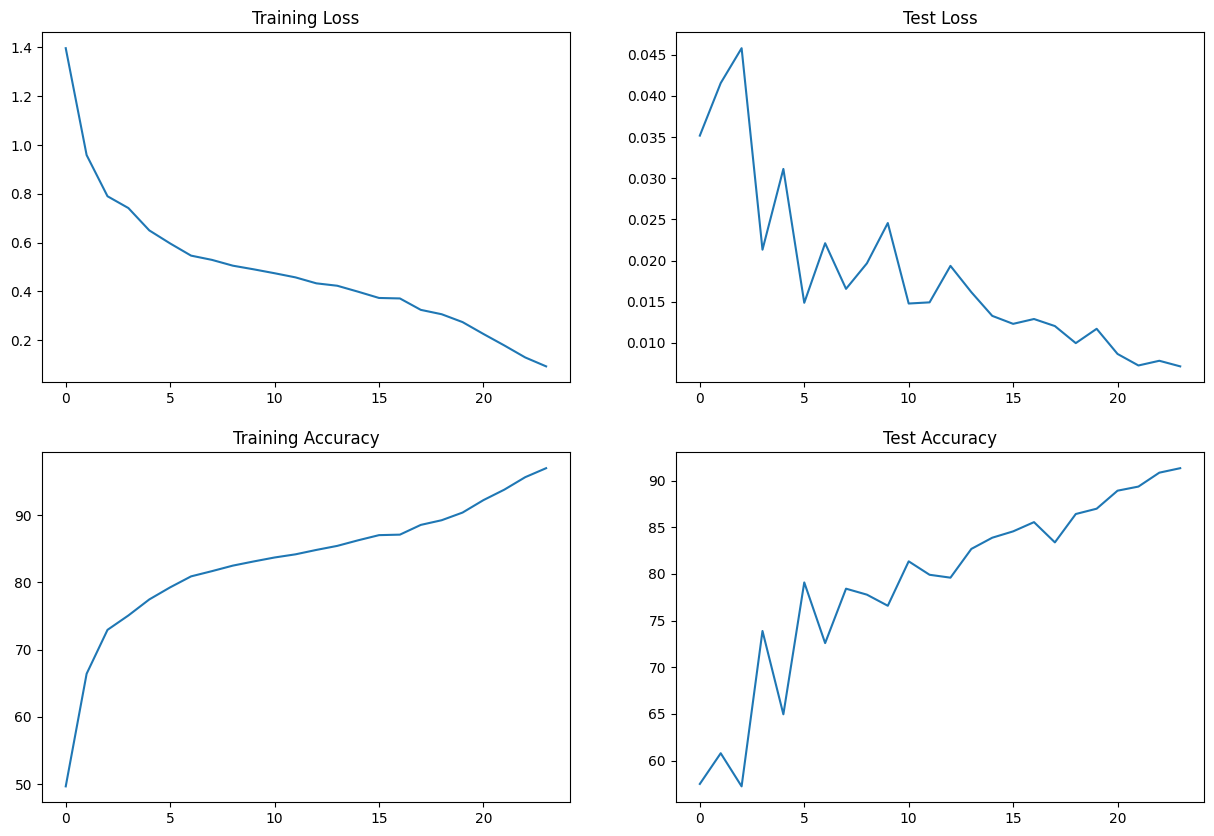

In [11]:
plot_accuracy_report(train_losses, test_loss_cpu, train_acc, test_acc)

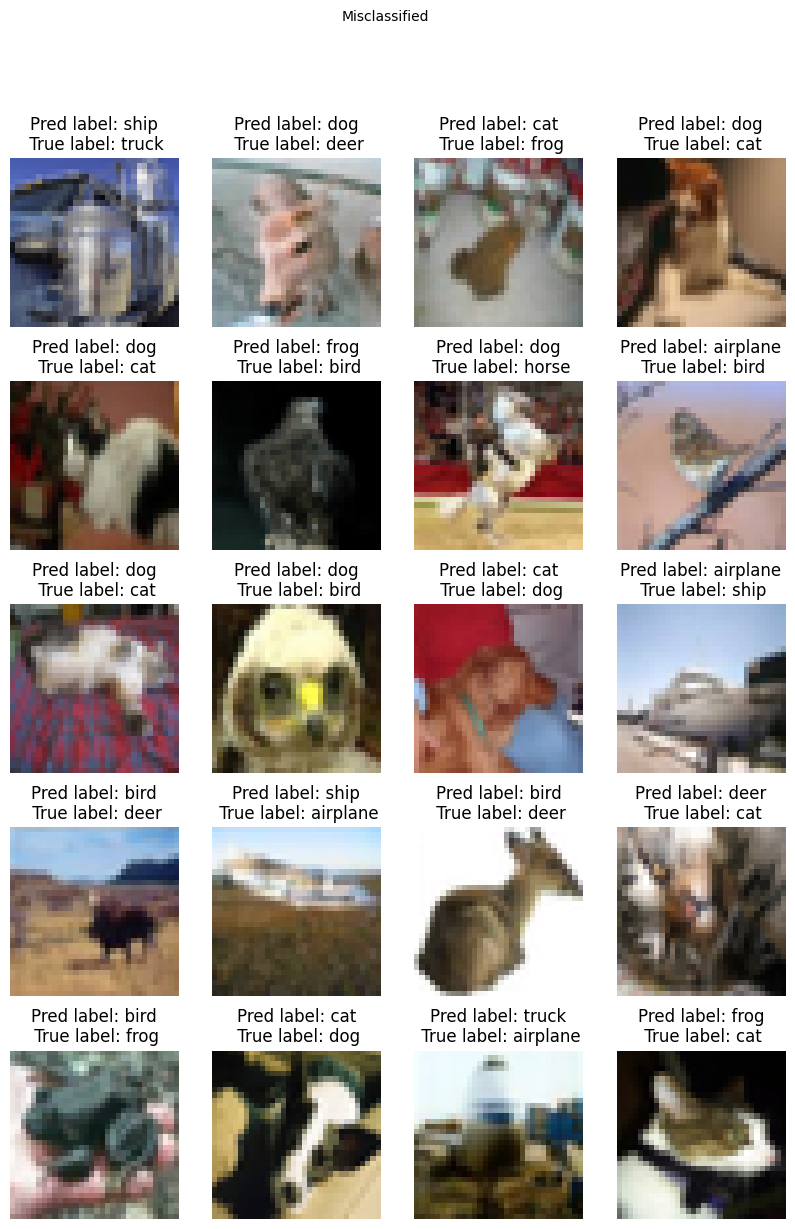

In [12]:
# from torchvision import transforms
# import matplotlib.pyplot as plt
# import numpy as np

grid_size = (4,4)
plot_misclassified(model,test_loader,test,device,mean,std)


Accuracy of airplane : 90 %

Accuracy of automobile : 100 %

Accuracy of  bird : 100 %

Accuracy of   cat : 73 %

Accuracy of  deer : 85 %

Accuracy of   dog : 92 %

Accuracy of  frog : 100 %

Accuracy of horse : 86 %

Accuracy of  ship : 95 %

Accuracy of truck : 95 %
{'airplane': 90.0, 'automobile': 100.0, 'bird': 100.0, 'cat': 73.6842105263158, 'deer': 85.0, 'dog': 92.0, 'frog': 100.0, 'horse': 86.36363636363636, 'ship': 95.0, 'truck': 95.65217391304348}


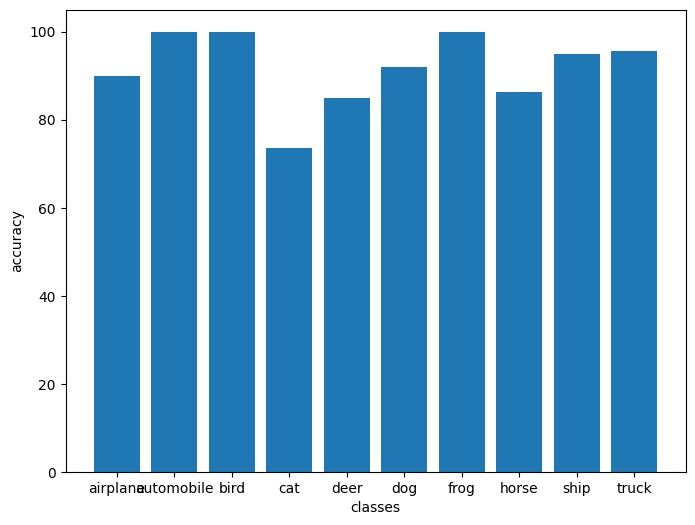

In [13]:
calculate_accuracy_per_class(model,device,test_loader,test)